In [16]:
import numpy as np
import torch.nn as nn
import torch
import random
import torch.nn.functional as F
from financial_models.option_price_models import BSM
from financial_models.asset_price_models import GBM
import matplotlib.pyplot as plt
import pandas as pd



class FullyConnected(nn.Module):
    def __init__(self, input, hidden, out_size, num_layers, f):
        super(FullyConnected, self).__init__()

        self.num_layers = num_layers

        self.first_layer = nn.Linear(input, hidden)

        self.linear = nn.ModuleList([nn.Linear(hidden, hidden) for _ in range(num_layers)])

        self.f = f

        self.out_layer = nn.Linear(hidden, out_size)

    def forward(self, x):
        x = self.f(self.first_layer(x))
        for layer in range(self.num_layers):
            x = self.linear[layer](x)
            x = self.f(x)

        x = self.f(x)
        x = self.out_layer(x)

        return x


def generate_data(apm, opm, num_steps, dt, n=3):
    D = []
    for j in range(n):
        apm.reset()
        price = apm.get_current_price()
        opt_price = opm.compute_option_price(T, price, mode="ttm")
        for p in range(num_steps):
            apm.compute_next_price()
            next_price = apm.get_current_price()
            next_opt_price = opm.compute_option_price(T - (p + 1) * dt, next_price, mode="ttm")
            delta = opm.compute_delta_ttm(T - p * dt, price)
            D.append({"p": price, "np": next_price, "op": opt_price, "nop": next_opt_price, "ttm": T - p * dt,
                      "nttm": T - (p + 1) * dt, "delta": delta})
            price = next_price
            opt_price = next_opt_price
    return D


def test(model, apm, opm, num_steps, dt, n=10):
    losses = []
    delta_losses = []
    for i in range(n):
        D = generate_data(apm, opm, num_steps, dt, n=1)
        old_delta = 0
        old_out = 0
        for tupel in D:
            inp = torch.tensor(np.array([old_out, tupel["p"], tupel["ttm"]])).double()
            out = model(inp)
            if i == 1:
                print(inp)
                print(out)

            trading_costs = (T / num_steps) * (abs(old_out - out) + 0.01 * (old_out - out) ** 2)
            pl = (-tupel["nop"] + tupel["op"]) + out * (tupel["np"] - tupel["p"]) - trading_costs
            loss = torch.pow(pl, 2) - 1 / 1000 * pl
            losses.append(loss.detach().numpy()[0])

            trading_costs_delta = (T / num_steps) * (abs(old_delta - tupel["delta"]) + 0.01 *
                                                     (old_delta - tupel["delta"]) ** 2)
            pl_delta = (-tupel["nop"] + tupel["op"]) + tupel["delta"] * (tupel["np"] - tupel["p"]) - trading_costs_delta
            delta_loss = (pl_delta) ** 2 - 1/1000 *pl_delta
            delta_losses.append(delta_loss)
            old_delta = tupel["delta"]
            old_out = out.detach().numpy()[0]
    return losses, delta_losses, np.mean(losses), np.mean(delta_losses)


volatility = 0.15
strike_price = 1
starting_price = 1
mu = 0.0
T = 1.0
num_steps = 128
dt = T / num_steps
risk_free_interest_rate = 0.01

seed = 345
np.random.seed(seed)
torch.manual_seed(seed)

model = FullyConnected(3, 16, 1, 5, f=torch.nn.functional.relu)
model.double()
apm = GBM(mu=mu, dt=dt, s_0=starting_price, sigma=volatility)
opm = BSM(strike_price=strike_price, risk_free_interest_rate=risk_free_interest_rate, volatility=volatility, T=T, dt=dt)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_eps = 800
norm_factor = 10000

test_res = []
test_res_delta = []



episode:  0
tensor([0., 1., 1.], dtype=torch.float64)
tensor([-0.0850], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0850,  1.0113,  0.9922], dtype=torch.float64)
tensor([-0.0850], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0850,  1.0020,  0.9844], dtype=torch.float64)
tensor([-0.0850], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0850,  1.0189,  0.9766], dtype=torch.float64)
tensor([-0.0850], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0850,  1.0318,  0.9688], dtype=torch.float64)
tensor([-0.0850], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0850,  1.0310,  0.9609], dtype=torch.float64)
tensor([-0.0850], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0850,  1.0256,  0.9531], dtype=torch.float64)
tensor([-0.0850], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0850,  1.0431,  0.9453], dtype=torch.float64)
tensor([-0.0850], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0850,  1.0628,  0.9375], dtype=t

tensor([-0.0847,  0.8515,  0.1719], dtype=torch.float64)
tensor([-0.0847], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0847,  0.8500,  0.1641], dtype=torch.float64)
tensor([-0.0847], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0847,  0.8594,  0.1562], dtype=torch.float64)
tensor([-0.0847], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0847,  0.8743,  0.1484], dtype=torch.float64)
tensor([-0.0847], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0847,  0.8565,  0.1406], dtype=torch.float64)
tensor([-0.0847], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0847,  0.8647,  0.1328], dtype=torch.float64)
tensor([-0.0847], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0847,  0.8531,  0.1250], dtype=torch.float64)
tensor([-0.0847], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0847,  0.8507,  0.1172], dtype=torch.float64)
tensor([-0.0847], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-0.0847,  0.8626,  0.1094], dtyp

test_result:  1.5439828849438335e-05 6.07355110863272e-07
loss: [189.74506026]
episode:  21
loss: [249.86054132]
episode:  22
loss: [333.57240741]
episode:  23
loss: [210.04192427]
episode:  24
loss: [243.51149549]
episode:  25
loss: [202.69693761]
episode:  26
loss: [175.20678121]
episode:  27
loss: [174.49016271]
episode:  28
loss: [223.10516531]
episode:  29
loss: [169.6783051]
episode:  30
loss: [219.8624938]
episode:  31
loss: [200.08993523]
episode:  32
loss: [182.72448659]
episode:  33
loss: [231.57177705]
episode:  34
loss: [135.61343525]
episode:  35
loss: [190.43949475]
episode:  36
loss: [183.69807767]
episode:  37
loss: [271.15377807]
episode:  38
loss: [266.36865688]
episode:  39
loss: [214.11230159]
episode:  40
tensor([0., 1., 1.], dtype=torch.float64)
tensor([0.5894], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5894, 0.9834, 0.9922], dtype=torch.float64)
tensor([0.5886], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5886, 0.9926, 0.9844], dtype=torch

tensor([0.5877], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5877, 1.0550, 0.3672], dtype=torch.float64)
tensor([0.5877], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5877, 1.0468, 0.3594], dtype=torch.float64)
tensor([0.5877], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5877, 1.0236, 0.3516], dtype=torch.float64)
tensor([0.5876], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5876, 1.0276, 0.3438], dtype=torch.float64)
tensor([0.5876], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5876, 1.0266, 0.3359], dtype=torch.float64)
tensor([0.5876], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5876, 1.0481, 0.3281], dtype=torch.float64)
tensor([0.5877], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5877, 1.0440, 0.3203], dtype=torch.float64)
tensor([0.5876], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5876, 1.0303, 0.3125], dtype=torch.float64)
tensor([0.5876], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.5670, 0.9519, 0.8281], dtype=torch.float64)
tensor([0.5670], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5670, 0.9551, 0.8203], dtype=torch.float64)
tensor([0.5670], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5670, 0.9649, 0.8125], dtype=torch.float64)
tensor([0.5670], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5670, 0.9547, 0.8047], dtype=torch.float64)
tensor([0.5670], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5670, 0.9669, 0.7969], dtype=torch.float64)
tensor([0.5670], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5670, 0.9718, 0.7891], dtype=torch.float64)
tensor([0.5670], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5670, 0.9734, 0.7812], dtype=torch.float64)
tensor([0.5670], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5670, 0.9816, 0.7734], dtype=torch.float64)
tensor([0.5670], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5670, 0.9699, 0.7656], dtype=torch.float64)
tensor([0.5670], d

test_result:  1.517092814483762e-05 6.9031849806856e-07
loss: [157.88547531]
episode:  61
loss: [208.23487307]
episode:  62
loss: [141.01603958]
episode:  63
loss: [216.83013523]
episode:  64
loss: [198.15513983]
episode:  65
loss: [163.19930071]
episode:  66
loss: [236.65757012]
episode:  67
loss: [196.68567365]
episode:  68
loss: [164.24541368]
episode:  69
loss: [241.69161739]
episode:  70
loss: [262.21752945]
episode:  71
loss: [192.80435463]
episode:  72
loss: [232.67417383]
episode:  73
loss: [163.0631097]
episode:  74
loss: [232.27772292]
episode:  75
loss: [210.19278069]
episode:  76
loss: [190.6131849]
episode:  77
loss: [169.08092199]
episode:  78
loss: [228.61816522]
episode:  79
loss: [186.6860728]
episode:  80
tensor([0., 1., 1.], dtype=torch.float64)
tensor([0.6003], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6003, 1.0216, 0.9922], dtype=torch.float64)
tensor([0.5976], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5976, 1.0228, 0.9844], dtype=torch.fl

tensor([0.5938, 0.8459, 0.3594], dtype=torch.float64)
tensor([0.5938], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5938, 0.8556, 0.3516], dtype=torch.float64)
tensor([0.5939], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5939, 0.8500, 0.3438], dtype=torch.float64)
tensor([0.5938], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5938, 0.8552, 0.3359], dtype=torch.float64)
tensor([0.5939], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5939, 0.8371, 0.3281], dtype=torch.float64)
tensor([0.5936], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5936, 0.8356, 0.3203], dtype=torch.float64)
tensor([0.5935], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5935, 0.8482, 0.3125], dtype=torch.float64)
tensor([0.5937], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5937, 0.8499, 0.3047], dtype=torch.float64)
tensor([0.5937], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5937, 0.8617, 0.2969], dtype=torch.float64)
tensor([0.5938], d

tensor([0.6031], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6031, 1.2538, 0.1328], dtype=torch.float64)
tensor([0.6033], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6033, 1.2381, 0.1250], dtype=torch.float64)
tensor([0.6027], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6027, 1.2153, 0.1172], dtype=torch.float64)
tensor([0.6019], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6019, 1.2309, 0.1094], dtype=torch.float64)
tensor([0.6025], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6025, 1.2344, 0.1016], dtype=torch.float64)
tensor([0.6026], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6026, 1.2352, 0.0938], dtype=torch.float64)
tensor([0.6026], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6026, 1.2288, 0.0859], dtype=torch.float64)
tensor([0.6024], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6024, 1.2287, 0.0781], dtype=torch.float64)
tensor([0.6024], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.5626, 0.9194, 0.5469], dtype=torch.float64)
tensor([0.5617], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5617, 0.9222, 0.5391], dtype=torch.float64)
tensor([0.5622], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5622, 0.9280, 0.5312], dtype=torch.float64)
tensor([0.5631], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5631, 0.8931, 0.5234], dtype=torch.float64)
tensor([0.5580], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5580, 0.8958, 0.5156], dtype=torch.float64)
tensor([0.5588], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5588, 0.8750, 0.5078], dtype=torch.float64)
tensor([0.5558], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5558, 0.8720, 0.5000], dtype=torch.float64)
tensor([0.5556], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5556, 0.8646, 0.4922], dtype=torch.float64)
tensor([0.5546], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5546, 0.8684, 0.4844], dtype=torch.float64)
tensor([0.5553], d

loss: [161.79714247]
episode:  122
loss: [181.86592002]
episode:  123
loss: [230.75804406]
episode:  124
loss: [173.53453616]
episode:  125
loss: [213.88243369]
episode:  126
loss: [119.84357121]
episode:  127
loss: [178.8039013]
episode:  128
loss: [199.92361394]
episode:  129
loss: [174.77188619]
episode:  130
loss: [186.33378131]
episode:  131
loss: [170.53041475]
episode:  132
loss: [200.28425472]
episode:  133
loss: [154.72869827]
episode:  134
loss: [142.3505111]
episode:  135
loss: [182.96691609]
episode:  136
loss: [155.95138349]
episode:  137
loss: [154.94295731]
episode:  138
loss: [173.38530866]
episode:  139
loss: [173.82897105]
episode:  140
tensor([0., 1., 1.], dtype=torch.float64)
tensor([0.6365], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6365, 0.9913, 0.9922], dtype=torch.float64)
tensor([0.4924], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4924, 0.9823, 0.9844], dtype=torch.float64)
tensor([0.5282], dtype=torch.float64, grad_fn=<AddBackward0>)
t

tensor([0.6040], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6040, 1.0905, 0.2812], dtype=torch.float64)
tensor([0.6001], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6001, 1.0987, 0.2734], dtype=torch.float64)
tensor([0.6070], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6070, 1.1004, 0.2656], dtype=torch.float64)
tensor([0.6063], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6063, 1.1073, 0.2578], dtype=torch.float64)
tensor([0.6114], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6114, 1.1249, 0.2500], dtype=torch.float64)
tensor([0.6211], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6211, 1.1418, 0.2422], dtype=torch.float64)
tensor([0.6289], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6289, 1.1645, 0.2344], dtype=torch.float64)
tensor([0.6410], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6410, 1.1589, 0.2266], dtype=torch.float64)
tensor([0.6340], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.5526, 0.9778, 0.7500], dtype=torch.float64)
tensor([0.5212], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5212, 0.9812, 0.7422], dtype=torch.float64)
tensor([0.5525], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5525, 0.9713, 0.7344], dtype=torch.float64)
tensor([0.5054], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5054, 0.9745, 0.7266], dtype=torch.float64)
tensor([0.5471], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5471, 0.9694, 0.7188], dtype=torch.float64)
tensor([0.5051], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5051, 0.9616, 0.7109], dtype=torch.float64)
tensor([0.5141], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5141, 0.9516, 0.7031], dtype=torch.float64)
tensor([0.4819], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4819, 0.9395, 0.6953], dtype=torch.float64)
tensor([0.4726], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4726, 0.9429, 0.6875], dtype=torch.float64)
tensor([0.4887], d

tensor([0.5417, 0.9310, 0.0625], dtype=torch.float64)
tensor([0.4681], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4681, 0.9454, 0.0547], dtype=torch.float64)
tensor([0.5463], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5463, 0.9670, 0.0469], dtype=torch.float64)
tensor([0.5499], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5499, 0.9516, 0.0391], dtype=torch.float64)
tensor([0.5129], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5129, 0.9513, 0.0312], dtype=torch.float64)
tensor([0.5325], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5325, 0.9448, 0.0234], dtype=torch.float64)
tensor([0.5075], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5075, 0.9460, 0.0156], dtype=torch.float64)
tensor([0.5236], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5236, 0.9393, 0.0078], dtype=torch.float64)
tensor([0.5007], dtype=torch.float64, grad_fn=<AddBackward0>)
test_result:  5.1738718282718396e-06 5.629428410339467e-07
loss: [69.208

tensor([0.7828], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7828, 1.1433, 0.2969], dtype=torch.float64)
tensor([0.7729], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7729, 1.1351, 0.2891], dtype=torch.float64)
tensor([0.7589], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7589, 1.1375, 0.2812], dtype=torch.float64)
tensor([0.7629], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7629, 1.1287, 0.2734], dtype=torch.float64)
tensor([0.7476], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7476, 1.1336, 0.2656], dtype=torch.float64)
tensor([0.7559], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7559, 1.1489, 0.2578], dtype=torch.float64)
tensor([0.7816], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7816, 1.1681, 0.2500], dtype=torch.float64)
tensor([0.8139], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8139, 1.1803, 0.2422], dtype=torch.float64)
tensor([0.8342], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.1265, 0.8922, 0.7266], dtype=torch.float64)
tensor([0.1200], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1200, 0.8997, 0.7188], dtype=torch.float64)
tensor([0.1205], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1205, 0.9087, 0.7109], dtype=torch.float64)
tensor([0.1326], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1326, 0.8898, 0.7031], dtype=torch.float64)
tensor([0.1200], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1200, 0.8834, 0.6953], dtype=torch.float64)
tensor([0.1199], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1199, 0.8840, 0.6875], dtype=torch.float64)
tensor([0.1199], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1199, 0.9006, 0.6797], dtype=torch.float64)
tensor([0.1209], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1209, 0.8969, 0.6719], dtype=torch.float64)
tensor([0.1200], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1200, 0.8982, 0.6641], dtype=torch.float64)
tensor([0.1200], d

test_result:  2.233289686098265e-06 6.395521138966553e-07
loss: [18.18508659]
episode:  201
loss: [17.62307948]
episode:  202
loss: [21.73383974]
episode:  203
loss: [23.1750503]
episode:  204
loss: [20.40685234]
episode:  205
loss: [31.80062882]
episode:  206
loss: [19.84233929]
episode:  207
loss: [34.93088119]
episode:  208
loss: [30.15686318]
episode:  209
loss: [32.06555036]
episode:  210
loss: [35.26755017]
episode:  211
loss: [31.58238518]
episode:  212
loss: [27.54524411]
episode:  213
loss: [24.54250814]
episode:  214
loss: [26.44944531]
episode:  215
loss: [38.38382644]
episode:  216
loss: [22.22223363]
episode:  217
loss: [18.72540967]
episode:  218
loss: [116.2931334]
episode:  219
loss: [60.2403848]
episode:  220
tensor([0., 1., 1.], dtype=torch.float64)
tensor([0.2751], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2751, 0.9887, 0.9922], dtype=torch.float64)
tensor([0.4323], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4323, 0.9965, 0.9844], dtype=torch

tensor([0.6034, 1.1512, 0.2500], dtype=torch.float64)
tensor([0.6077], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6077, 1.1697, 0.2422], dtype=torch.float64)
tensor([0.6160], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6160, 1.1472, 0.2344], dtype=torch.float64)
tensor([0.6059], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6059, 1.1698, 0.2266], dtype=torch.float64)
tensor([0.6158], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6158, 1.1783, 0.2188], dtype=torch.float64)
tensor([0.6197], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6197, 1.1768, 0.2109], dtype=torch.float64)
tensor([0.6190], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6190, 1.1706, 0.2031], dtype=torch.float64)
tensor([0.6161], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6161, 1.1664, 0.1953], dtype=torch.float64)
tensor([0.6141], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6141, 1.1525, 0.1875], dtype=torch.float64)
tensor([0.6078], d

tensor([1.0151, 1.2131, 0.3047], dtype=torch.float64)
tensor([1.0026], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0026, 1.1962, 0.2969], dtype=torch.float64)
tensor([0.9753], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9753, 1.1894, 0.2891], dtype=torch.float64)
tensor([0.9633], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9633, 1.2106, 0.2812], dtype=torch.float64)
tensor([0.9961], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9961, 1.1866, 0.2734], dtype=torch.float64)
tensor([0.9599], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9599, 1.1989, 0.2656], dtype=torch.float64)
tensor([0.9775], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9775, 1.1839, 0.2578], dtype=torch.float64)
tensor([0.9548], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9548, 1.1692, 0.2500], dtype=torch.float64)
tensor([0.9305], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9305, 1.1543, 0.2422], dtype=torch.float64)
tensor([0.9060], d

tensor([0.1150, 0.8480, 0.2969], dtype=torch.float64)
tensor([0.1150], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1150, 0.8540, 0.2891], dtype=torch.float64)
tensor([0.1154], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1154, 0.8379, 0.2812], dtype=torch.float64)
tensor([0.1148], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1148, 0.8311, 0.2734], dtype=torch.float64)
tensor([0.1146], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1146, 0.8216, 0.2656], dtype=torch.float64)
tensor([0.1145], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1145, 0.8260, 0.2578], dtype=torch.float64)
tensor([0.1145], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1145, 0.8077, 0.2500], dtype=torch.float64)
tensor([0.1145], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1145, 0.8097, 0.2422], dtype=torch.float64)
tensor([0.1145], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1145, 0.8298, 0.2344], dtype=torch.float64)
tensor([0.1146], d

tensor([0.4984, 0.9623, 0.0938], dtype=torch.float64)
tensor([0.4844], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4844, 0.9412, 0.0859], dtype=torch.float64)
tensor([0.4183], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4183, 0.9328, 0.0781], dtype=torch.float64)
tensor([0.3821], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3821, 0.9238, 0.0703], dtype=torch.float64)
tensor([0.3482], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3482, 0.9374, 0.0625], dtype=torch.float64)
tensor([0.3842], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3842, 0.9217, 0.0547], dtype=torch.float64)
tensor([0.3410], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3410, 0.9396, 0.0469], dtype=torch.float64)
tensor([0.3888], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3888, 0.9317, 0.0391], dtype=torch.float64)
tensor([0.3712], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3712, 0.9474, 0.0312], dtype=torch.float64)
tensor([0.4160], d

tensor([0.1220, 0.8979, 0.3359], dtype=torch.float64)
tensor([0.1392], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1392, 0.9115, 0.3281], dtype=torch.float64)
tensor([0.1800], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1800, 0.9082, 0.3203], dtype=torch.float64)
tensor([0.1777], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1777, 0.9240, 0.3125], dtype=torch.float64)
tensor([0.2263], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2263, 0.9166, 0.3047], dtype=torch.float64)
tensor([0.2125], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2125, 0.9443, 0.2969], dtype=torch.float64)
tensor([0.2988], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2988, 0.9595, 0.2891], dtype=torch.float64)
tensor([0.3660], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3660, 0.9644, 0.2812], dtype=torch.float64)
tensor([0.3958], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3958, 0.9808, 0.2734], dtype=torch.float64)
tensor([0.4548], d

tensor([0.8922, 1.1446, 0.5156], dtype=torch.float64)
tensor([0.8766], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8766, 1.1480, 0.5078], dtype=torch.float64)
tensor([0.8790], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8790, 1.1572, 0.5000], dtype=torch.float64)
tensor([0.8888], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8888, 1.1481, 0.4922], dtype=torch.float64)
tensor([0.8805], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8805, 1.1645, 0.4844], dtype=torch.float64)
tensor([0.8968], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8968, 1.1729, 0.4766], dtype=torch.float64)
tensor([0.9070], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9070, 1.1789, 0.4688], dtype=torch.float64)
tensor([0.9141], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9141, 1.1956, 0.4609], dtype=torch.float64)
tensor([0.9318], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9318, 1.1892, 0.4531], dtype=torch.float64)
tensor([0.9261], d

loss: [15.93005761]
episode:  336
loss: [13.53610679]
episode:  337
loss: [12.56636591]
episode:  338
loss: [24.30347106]
episode:  339
loss: [12.40590462]
episode:  340
tensor([0., 1., 1.], dtype=torch.float64)
tensor([0.3457], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3457, 0.9941, 0.9922], dtype=torch.float64)
tensor([0.5386], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5386, 1.0136, 0.9844], dtype=torch.float64)
tensor([0.6225], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6225, 1.0068, 0.9766], dtype=torch.float64)
tensor([0.6205], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6205, 0.9962, 0.9688], dtype=torch.float64)
tensor([0.5881], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5881, 1.0069, 0.9609], dtype=torch.float64)
tensor([0.6117], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6117, 0.9941, 0.9531], dtype=torch.float64)
tensor([0.5774], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5774, 0.9965, 0.9453

tensor([0.0809], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0809, 0.8684, 0.4219], dtype=torch.float64)
tensor([0.0808], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0808, 0.8577, 0.4141], dtype=torch.float64)
tensor([0.0806], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0806, 0.8486, 0.4062], dtype=torch.float64)
tensor([0.0806], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0806, 0.8445, 0.3984], dtype=torch.float64)
tensor([0.0806], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0806, 0.8363, 0.3906], dtype=torch.float64)
tensor([0.0806], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0806, 0.8487, 0.3828], dtype=torch.float64)
tensor([0.0806], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0806, 0.8541, 0.3750], dtype=torch.float64)
tensor([0.0806], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0806, 0.8687, 0.3672], dtype=torch.float64)
tensor([0.0808], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.7500, 1.0665, 0.1797], dtype=torch.float64)
tensor([0.7906], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7906, 1.1110, 0.1719], dtype=torch.float64)
tensor([0.8582], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8582, 1.1047, 0.1641], dtype=torch.float64)
tensor([0.8562], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8562, 1.1109, 0.1562], dtype=torch.float64)
tensor([0.8624], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8624, 1.0872, 0.1484], dtype=torch.float64)
tensor([0.8389], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8389, 1.0772, 0.1406], dtype=torch.float64)
tensor([0.8245], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8245, 1.0815, 0.1328], dtype=torch.float64)
tensor([0.8310], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8310, 1.0885, 0.1250], dtype=torch.float64)
tensor([0.8386], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8386, 1.1010, 0.1172], dtype=torch.float64)
tensor([0.8517], d

test_result:  9.907781776985475e-07 5.778185205200171e-07
loss: [17.86984286]
episode:  381
loss: [22.35320444]
episode:  382
loss: [12.6043091]
episode:  383
loss: [9.98987474]
episode:  384
loss: [15.28343112]
episode:  385
loss: [13.78777774]
episode:  386
loss: [10.98671527]
episode:  387
loss: [12.85411092]
episode:  388
loss: [12.87273681]
episode:  389
loss: [12.05964218]
episode:  390
loss: [19.43016842]
episode:  391
loss: [11.3570206]
episode:  392
loss: [10.5062315]
episode:  393
loss: [16.44478771]
episode:  394
loss: [17.95024853]
episode:  395
loss: [14.88071118]
episode:  396
loss: [14.57971734]
episode:  397
loss: [11.4054709]
episode:  398
loss: [14.85196639]
episode:  399
loss: [15.61044729]
episode:  400
tensor([0., 1., 1.], dtype=torch.float64)
tensor([0.3428], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3428, 1.0353, 0.9922], dtype=torch.float64)
tensor([0.6304], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6304, 1.0351, 0.9844], dtype=torch.fl

tensor([0.2002, 0.9399, 0.0859], dtype=torch.float64)
tensor([0.2307], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2307, 0.9405, 0.0781], dtype=torch.float64)
tensor([0.2413], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2413, 0.9290, 0.0703], dtype=torch.float64)
tensor([0.2061], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2061, 0.9245, 0.0625], dtype=torch.float64)
tensor([0.1830], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1830, 0.9316, 0.0547], dtype=torch.float64)
tensor([0.1965], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1965, 0.9579, 0.0469], dtype=torch.float64)
tensor([0.2852], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2852, 0.9479, 0.0391], dtype=torch.float64)
tensor([0.2788], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2788, 0.9270, 0.0312], dtype=torch.float64)
tensor([0.2074], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2074, 0.9480, 0.0234], dtype=torch.float64)
tensor([0.2534], d

tensor([0.9208], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9208, 1.1864, 0.4219], dtype=torch.float64)
tensor([0.9459], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9459, 1.1874, 0.4141], dtype=torch.float64)
tensor([0.9496], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9496, 1.2076, 0.4062], dtype=torch.float64)
tensor([0.9702], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9702, 1.2290, 0.3984], dtype=torch.float64)
tensor([0.9931], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9931, 1.2169, 0.3906], dtype=torch.float64)
tensor([0.9826], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9826, 1.2113, 0.3828], dtype=torch.float64)
tensor([0.9764], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9764, 1.2270, 0.3750], dtype=torch.float64)
tensor([0.9918], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9918, 1.2316, 0.3672], dtype=torch.float64)
tensor([0.9975], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.5361, 1.0011, 0.8516], dtype=torch.float64)
tensor([0.5643], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5643, 1.0115, 0.8438], dtype=torch.float64)
tensor([0.5978], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5978, 0.9895, 0.8359], dtype=torch.float64)
tensor([0.5412], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5412, 0.9858, 0.8281], dtype=torch.float64)
tensor([0.5167], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5167, 1.0047, 0.8203], dtype=torch.float64)
tensor([0.5636], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5636, 1.0040, 0.8125], dtype=torch.float64)
tensor([0.5701], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5701, 1.0175, 0.8047], dtype=torch.float64)
tensor([0.6095], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6095, 1.0175, 0.7969], dtype=torch.float64)
tensor([0.6181], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6181, 1.0082, 0.7891], dtype=torch.float64)
tensor([0.5956], d

tensor([0.1276], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1276, 0.9034, 0.1406], dtype=torch.float64)
tensor([0.1103], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1103, 0.9010, 0.1328], dtype=torch.float64)
tensor([0.1025], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1025, 0.8898, 0.1250], dtype=torch.float64)
tensor([0.0819], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0819, 0.9097, 0.1172], dtype=torch.float64)
tensor([0.1216], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1216, 0.9128, 0.1094], dtype=torch.float64)
tensor([0.1251], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1251, 0.9110, 0.1016], dtype=torch.float64)
tensor([0.1221], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1221, 0.9347, 0.0938], dtype=torch.float64)
tensor([0.1849], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1849, 0.9272, 0.0859], dtype=torch.float64)
tensor([0.1799], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.7625, 1.0814, 0.2109], dtype=torch.float64)
tensor([0.8073], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8073, 1.0771, 0.2031], dtype=torch.float64)
tensor([0.8080], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8080, 1.0570, 0.1953], dtype=torch.float64)
tensor([0.7710], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7710, 1.0533, 0.1875], dtype=torch.float64)
tensor([0.7565], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7565, 1.0214, 0.1797], dtype=torch.float64)
tensor([0.6650], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6650, 1.0338, 0.1719], dtype=torch.float64)
tensor([0.6776], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6776, 1.0248, 0.1641], dtype=torch.float64)
tensor([0.6518], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6518, 1.0050, 0.1562], dtype=torch.float64)
tensor([0.5794], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5794, 0.9963, 0.1484], dtype=torch.float64)
tensor([0.5287], d

tensor([0.8833], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8833, 1.1526, 0.4375], dtype=torch.float64)
tensor([0.8991], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8991, 1.1190, 0.4297], dtype=torch.float64)
tensor([0.8681], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8681, 1.1411, 0.4219], dtype=torch.float64)
tensor([0.8868], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8868, 1.1276, 0.4141], dtype=torch.float64)
tensor([0.8757], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8757, 1.1049, 0.4062], dtype=torch.float64)
tensor([0.8527], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8527, 1.1023, 0.3984], dtype=torch.float64)
tensor([0.8481], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8481, 1.0936, 0.3906], dtype=torch.float64)
tensor([0.8343], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8343, 1.0896, 0.3828], dtype=torch.float64)
tensor([0.8248], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.8623, 1.1104, 0.3125], dtype=torch.float64)
tensor([0.8603], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8603, 1.1410, 0.3047], dtype=torch.float64)
tensor([0.8900], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8900, 1.1677, 0.2969], dtype=torch.float64)
tensor([0.9190], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9190, 1.1913, 0.2891], dtype=torch.float64)
tensor([0.9444], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9444, 1.1804, 0.2812], dtype=torch.float64)
tensor([0.9355], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9355, 1.1979, 0.2734], dtype=torch.float64)
tensor([0.9521], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9521, 1.2215, 0.2656], dtype=torch.float64)
tensor([0.9763], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9763, 1.2035, 0.2578], dtype=torch.float64)
tensor([0.9604], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9604, 1.2161, 0.2500], dtype=torch.float64)
tensor([0.9718], d

tensor([0.5520, 0.9916, 0.2500], dtype=torch.float64)
tensor([0.5180], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5180, 0.9920, 0.2422], dtype=torch.float64)
tensor([0.5080], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5080, 0.9895, 0.2344], dtype=torch.float64)
tensor([0.4961], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4961, 1.0012, 0.2266], dtype=torch.float64)
tensor([0.5297], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5297, 1.0183, 0.2188], dtype=torch.float64)
tensor([0.5940], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5940, 1.0104, 0.2109], dtype=torch.float64)
tensor([0.5876], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5876, 1.0327, 0.2031], dtype=torch.float64)
tensor([0.6562], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6562, 1.0427, 0.1953], dtype=torch.float64)
tensor([0.7086], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7086, 1.0404, 0.1875], dtype=torch.float64)
tensor([0.7142], d

tensor([0.7373, 1.0468, 0.7422], dtype=torch.float64)
tensor([0.7062], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7062, 1.0322, 0.7344], dtype=torch.float64)
tensor([0.6699], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6699, 1.0403, 0.7266], dtype=torch.float64)
tensor([0.6797], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6797, 1.0296, 0.7188], dtype=torch.float64)
tensor([0.6599], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6599, 1.0477, 0.7109], dtype=torch.float64)
tensor([0.6937], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6937, 1.0455, 0.7031], dtype=torch.float64)
tensor([0.6967], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6967, 1.0778, 0.6953], dtype=torch.float64)
tensor([0.7647], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7647, 1.0697, 0.6875], dtype=torch.float64)
tensor([0.7622], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7622, 1.0917, 0.6797], dtype=torch.float64)
tensor([0.8038], d

tensor([0.9863], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9863, 1.2491, 0.0391], dtype=torch.float64)
tensor([1.0087], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0087, 1.2292, 0.0312], dtype=torch.float64)
tensor([0.9908], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9908, 1.2286, 0.0234], dtype=torch.float64)
tensor([0.9891], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9891, 1.2137, 0.0156], dtype=torch.float64)
tensor([0.9746], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9746, 1.2093, 0.0078], dtype=torch.float64)
tensor([0.9694], dtype=torch.float64, grad_fn=<AddBackward0>)
test_result:  1.2825378366395432e-06 7.999931626317338e-07
loss: [16.61998542]
episode:  541
loss: [13.05256797]
episode:  542
loss: [11.39977289]
episode:  543
loss: [15.31322427]
episode:  544
loss: [14.56775378]
episode:  545
loss: [16.11253044]
episode:  546
loss: [14.1209702]
episode:  547
loss: [12.18604123]
episode:  548
loss: [13.88216062]
episode:

tensor([0.6294], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6294, 1.0230, 0.1484], dtype=torch.float64)
tensor([0.6331], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6331, 1.0286, 0.1406], dtype=torch.float64)
tensor([0.6513], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6513, 1.0459, 0.1328], dtype=torch.float64)
tensor([0.7117], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7117, 1.0038, 0.1250], dtype=torch.float64)
tensor([0.5943], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5943, 0.9979, 0.1172], dtype=torch.float64)
tensor([0.5389], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.5389, 0.9911, 0.1094], dtype=torch.float64)
tensor([0.4990], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4990, 0.9871, 0.1016], dtype=torch.float64)
tensor([0.4730], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4730, 0.9861, 0.0938], dtype=torch.float64)
tensor([0.4608], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.6425, 1.0298, 0.2812], dtype=torch.float64)
tensor([0.6669], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6669, 1.0176, 0.2734], dtype=torch.float64)
tensor([0.6357], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6357, 1.0282, 0.2656], dtype=torch.float64)
tensor([0.6603], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6603, 1.0333, 0.2578], dtype=torch.float64)
tensor([0.6817], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6817, 1.0244, 0.2500], dtype=torch.float64)
tensor([0.6598], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.6598, 1.0407, 0.2422], dtype=torch.float64)
tensor([0.7039], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7039, 1.0687, 0.2344], dtype=torch.float64)
tensor([0.7729], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7729, 1.0671, 0.2266], dtype=torch.float64)
tensor([0.7830], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7830, 1.0754, 0.2188], dtype=torch.float64)
tensor([0.8006], d

tensor([0.3046], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3046, 0.9352, 0.2266], dtype=torch.float64)
tensor([0.2552], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2552, 0.9336, 0.2188], dtype=torch.float64)
tensor([0.2341], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2341, 0.9379, 0.2109], dtype=torch.float64)
tensor([0.2408], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2408, 0.9091, 0.2031], dtype=torch.float64)
tensor([0.1546], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1546, 0.8957, 0.1953], dtype=torch.float64)
tensor([0.1048], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1048, 0.9169, 0.1875], dtype=torch.float64)
tensor([0.1385], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1385, 0.9135, 0.1797], dtype=torch.float64)
tensor([0.1376], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1376, 0.9201, 0.1719], dtype=torch.float64)
tensor([0.1555], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8479, 0.3750], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8534, 0.3672], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8652, 0.3594], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8518, 0.3516], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8474, 0.3438], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8346, 0.3359], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8361, 0.3281], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8444, 0.3203], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.

tensor([0.0732, 0.8379, 0.3672], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8335, 0.3594], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8051, 0.3516], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8066, 0.3438], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8059, 0.3359], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8200, 0.3281], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8282, 0.3203], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8160, 0.3125], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8198, 0.3047], dtype=torch.float64)
tensor([0.0732], d

tensor([0.8471, 1.0866, 0.4844], dtype=torch.float64)
tensor([0.8195], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8195, 1.0918, 0.4766], dtype=torch.float64)
tensor([0.8244], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8244, 1.0853, 0.4688], dtype=torch.float64)
tensor([0.8137], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8137, 1.0832, 0.4609], dtype=torch.float64)
tensor([0.8083], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8083, 1.0867, 0.4531], dtype=torch.float64)
tensor([0.8140], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8140, 1.0986, 0.4453], dtype=torch.float64)
tensor([0.8374], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8374, 1.1074, 0.4375], dtype=torch.float64)
tensor([0.8520], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8520, 1.1106, 0.4297], dtype=torch.float64)
tensor([0.8568], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8568, 1.1084, 0.4219], dtype=torch.float64)
tensor([0.8553], d

tensor([0.1494, 0.9013, 0.4375], dtype=torch.float64)
tensor([0.1253], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1253, 0.9087, 0.4297], dtype=torch.float64)
tensor([0.1389], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1389, 0.8994, 0.4219], dtype=torch.float64)
tensor([0.1192], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1192, 0.9026, 0.4141], dtype=torch.float64)
tensor([0.1213], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1213, 0.8986, 0.4062], dtype=torch.float64)
tensor([0.1138], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1138, 0.8919, 0.3984], dtype=torch.float64)
tensor([0.0999], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0999, 0.8951, 0.3906], dtype=torch.float64)
tensor([0.1030], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1030, 0.8875, 0.3828], dtype=torch.float64)
tensor([0.0892], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0892, 0.9007, 0.3750], dtype=torch.float64)
tensor([0.1107], d

tensor([0.1818, 0.9291, 0.2969], dtype=torch.float64)
tensor([0.2041], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2041, 0.9306, 0.2891], dtype=torch.float64)
tensor([0.2154], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2154, 0.9332, 0.2812], dtype=torch.float64)
tensor([0.2264], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2264, 0.9332, 0.2734], dtype=torch.float64)
tensor([0.2291], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2291, 0.9224, 0.2656], dtype=torch.float64)
tensor([0.1940], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1940, 0.9387, 0.2578], dtype=torch.float64)
tensor([0.2356], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2356, 0.9815, 0.2500], dtype=torch.float64)
tensor([0.3869], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.3869, 0.9903, 0.2422], dtype=torch.float64)
tensor([0.4619], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.4619, 0.9760, 0.2344], dtype=torch.float64)
tensor([0.4378], d

tensor([0.8049, 1.0928, 0.3984], dtype=torch.float64)
tensor([0.8274], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8274, 1.0870, 0.3906], dtype=torch.float64)
tensor([0.8214], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8214, 1.0719, 0.3828], dtype=torch.float64)
tensor([0.7926], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7926, 1.0736, 0.3750], dtype=torch.float64)
tensor([0.7910], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7910, 1.0658, 0.3672], dtype=torch.float64)
tensor([0.7765], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7765, 1.0824, 0.3594], dtype=torch.float64)
tensor([0.8050], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8050, 1.1084, 0.3516], dtype=torch.float64)
tensor([0.8521], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8521, 1.1119, 0.3438], dtype=torch.float64)
tensor([0.8604], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8604, 1.1172, 0.3359], dtype=torch.float64)
tensor([0.8665], d

tensor([0.1091, 0.9159, 0.4766], dtype=torch.float64)
tensor([0.1584], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1584, 0.9050, 0.4688], dtype=torch.float64)
tensor([0.1406], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1406, 0.9189, 0.4609], dtype=torch.float64)
tensor([0.1745], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1745, 0.9361, 0.4531], dtype=torch.float64)
tensor([0.2397], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2397, 0.9276, 0.4453], dtype=torch.float64)
tensor([0.2316], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2316, 0.9204, 0.4375], dtype=torch.float64)
tensor([0.2049], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.2049, 0.9159, 0.4297], dtype=torch.float64)
tensor([0.1813], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1813, 0.9021, 0.4219], dtype=torch.float64)
tensor([0.1352], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.1352, 0.9066, 0.4141], dtype=torch.float64)
tensor([0.1347], d

tensor([0.0732, 0.8139, 0.4531], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8357, 0.4453], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8252, 0.4375], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8313, 0.4297], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8357, 0.4219], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8418, 0.4141], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8417, 0.4062], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8300, 0.3984], dtype=torch.float64)
tensor([0.0732], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0732, 0.8286, 0.3906], dtype=torch.float64)
tensor([0.0732], d

tensor([0.7089, 1.0733, 0.9297], dtype=torch.float64)
tensor([0.7482], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7482, 1.0740, 0.9219], dtype=torch.float64)
tensor([0.7560], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7560, 1.0669, 0.9141], dtype=torch.float64)
tensor([0.7429], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7429, 1.0741, 0.9062], dtype=torch.float64)
tensor([0.7544], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7544, 1.0564, 0.8984], dtype=torch.float64)
tensor([0.7210], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7210, 1.0750, 0.8906], dtype=torch.float64)
tensor([0.7526], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7526, 1.0842, 0.8828], dtype=torch.float64)
tensor([0.7779], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.7779, 1.1019, 0.8750], dtype=torch.float64)
tensor([0.8157], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.8157, 1.0872, 0.8672], dtype=torch.float64)
tensor([0.7958], d

tensor([1.0147, 1.2540, 0.1953], dtype=torch.float64)
tensor([1.0135], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0135, 1.2499, 0.1875], dtype=torch.float64)
tensor([1.0095], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0095, 1.2362, 0.1797], dtype=torch.float64)
tensor([0.9959], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9959, 1.2600, 0.1719], dtype=torch.float64)
tensor([1.0183], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0183, 1.2348, 0.1641], dtype=torch.float64)
tensor([0.9953], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.9953, 1.2537, 0.1562], dtype=torch.float64)
tensor([1.0123], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0123, 1.2699, 0.1484], dtype=torch.float64)
tensor([1.0293], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0293, 1.2708, 0.1406], dtype=torch.float64)
tensor([1.0314], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([1.0314, 1.2460, 0.1328], dtype=torch.float64)
tensor([1.0075], d

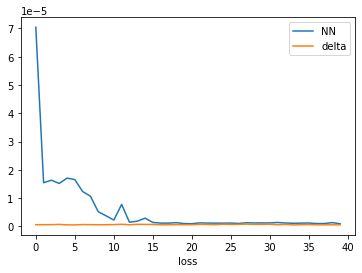

In [17]:
for i in range(num_eps):
    print("episode: ", i)

    if i % 20 == 0:
        losses, delta_losses, test_result, delta_test_results = test(model, apm, opm, num_steps=num_steps, dt=dt, n=20)
        print("test_result: ", test_result, delta_test_results)
        test_res.append(test_result)
        test_res_delta.append(delta_test_results)

    if i == 300:
        for q in optimizer.param_groups:
            q["lr"] = 0.001

    if i == 400:
        for q in optimizer.param_groups:
            q["lr"] = 0.0001

    if i == 500:
        for q in optimizer.param_groups:
            q["lr"] = 0.00001

    if i == 600:
        for q in optimizer.param_groups:
            q["lr"] = 0.000001

    if i == 700:
        for q in optimizer.param_groups:
            q["lr"] = 0.0000001

    loss = 0
    for _ in range(10):
        D = generate_data(apm, opm, num_steps, dt, n=1)
        old_out = 0
        for tupel in D:
            inp = torch.tensor(np.array([old_out, tupel["p"], tupel["ttm"]]), dtype=torch.float64)
            out = model(inp)
            trading_costs = (T / num_steps) * (abs(old_out - out) + 0.01 * (old_out - out) ** 2)
            pl = (-tupel["nop"] + tupel["op"]) + out * (tupel["np"] - tupel["p"]) - trading_costs
            loss += norm_factor * (torch.pow(pl, 2) - 1 / 1000 * pl)
            old_out = out.detach().numpy()[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("loss:", loss.detach().numpy())

print(test_res)
print(test_res_delta)
plt.plot(test_res, label="NN")
plt.plot(test_res_delta, label="delta")
# plt.xlabel("")
plt.xlabel("loss")
plt.legend()
plt.savefig("test_deep_classic_new_no_delta_losses_final_new_2_cost_1000.png")

torch.save(model, "model_classic_final_new_2_cost_1000.pth")


[7.040437300994911e-05, 1.5439828849438335e-05, 1.6317819685764417e-05, 1.517092814483762e-05, 1.7057597142239386e-05, 1.6538777006136722e-05, 1.2317469984923952e-05, 1.0676666278434035e-05, 5.1738718282718396e-06, 3.73697359201294e-06, 2.233289686098265e-06, 7.757069185611964e-06, 1.4607591117994787e-06, 1.839622916122992e-06, 2.8995275063102885e-06, 1.3945548903381885e-06, 1.1636412784827283e-06, 1.1498938026172045e-06, 1.3110746643984342e-06, 9.907781776985475e-07, 9.389030241218405e-07, 1.2327110548078983e-06, 1.1687066804841264e-06, 1.143851201128583e-06, 1.1345340944343285e-06, 1.1672801331643367e-06, 1.0379932397602214e-06, 1.2825378366395432e-06, 1.2056793133030061e-06, 1.2191772077753457e-06, 1.2245672316444167e-06, 1.3711056667786908e-06, 1.1820310409578912e-06, 1.0954486773600324e-06, 1.15028532115061e-06, 1.1820244832312547e-06, 9.840226238711097e-07, 1.0098884957610105e-06, 1.3342597873681313e-06, 9.019351401227029e-07]
[5.745904537411398e-07, 6.07355110863272e-07, 6.08176

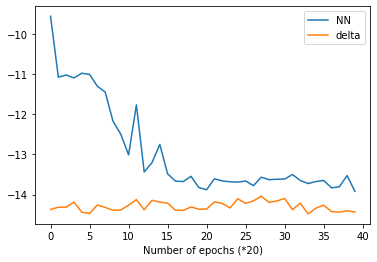

In [18]:
print(test_res)
print(test_res_delta)
plt.plot(np.log(test_res), label="NN")
plt.plot(np.log(test_res_delta), label="delta")
# plt.xlabel("")
plt.ylabel("")
plt.xlabel("Number of epochs (*20)")
plt.legend()
plt.savefig("test_deep_classic_new_no_delta_losses_final_new_2_cost_1000.png")

torch.save(model, "model_classic_final_new_2_cost_1000.pth")


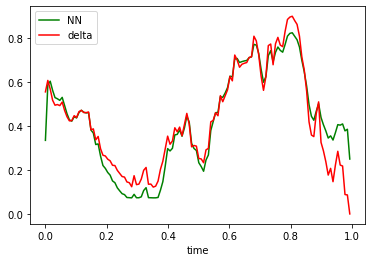

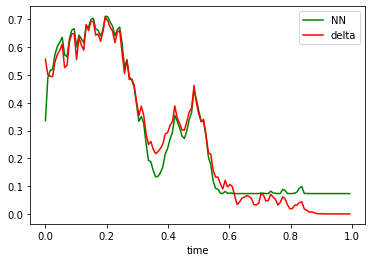

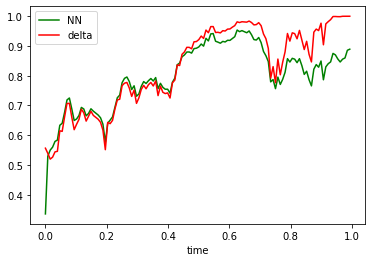

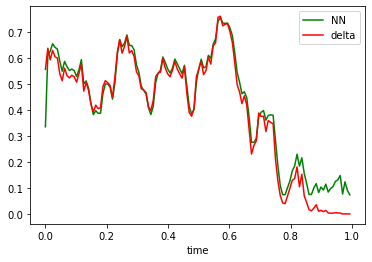

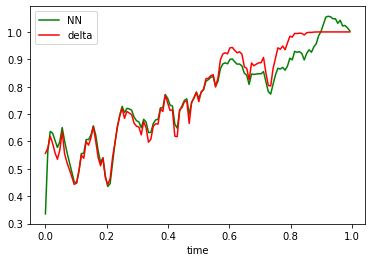

[1.4113922267707686e-06, 4.962424323335317e-07, 1.2198518252353178e-06, 8.130555893705317e-07, 8.86714933048566e-07, 7.183821481926228e-07, 7.668178073803733e-07, 7.671199362631218e-07, 1.444618203849193e-06, 9.879660843557931e-07, 1.366446770315942e-06, 7.07334789282269e-07, 6.518079698224703e-07, 9.678683383663682e-07, 1.0550119214209368e-06, 6.270501438849399e-07, 5.038772229059507e-07, 6.525217543052944e-07, 4.948116390308717e-07, 1.6022118846792474e-06]
9.070551810407057e-07 3.317514446313991e-07
[-0.02240451396189718, -0.02061250310341718, -0.0144149623645447, -0.002241030372923062, -0.024151417133236805, -0.0193373478562097, -0.019816439772819303, -0.02334833916888715, -0.012536045797651416, -0.0823846223922736, -0.02949534115523078, -0.02337977332855333, -0.020314765150207855, -0.03576925703959329, -0.025364653241191137, -0.022140508511657175, -0.034496750718286645, -0.021434877871736743, -0.05076698275838652, -0.026026415255519925, -0.026157372233977638, -0.035367363991322974,

In [25]:

for i in range(5):
    out = []
    delta = []
    plt.figure()
    D = generate_data(apm, opm, num_steps, dt, n=1)
    old_out = 0
    for tupel in D:
        inp = torch.tensor(np.array([old_out, tupel["p"], tupel["ttm"]])).double()
        out.append(model(inp).detach().numpy()[0])
        delta.append(tupel["delta"])
        old_out = out[-1]
    plt.plot([i / len(out) for i in range(len(out))], out, label="NN", color="green")
    plt.plot([i / len(delta) for i in range(len(delta))], delta, label="delta", color="red")
    plt.xlabel("time")
    # plt.xlabel("")
    plt.legend()
    plt.savefig("test_deep_classic_new_no_delta_final_new_2_cost_1000" + str(i) + ".png")
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

test_res = []
delta_res = []
for i in range(20):
    losses, delta_losses, test_result, delta_test_results = test(model, apm, opm, num_steps=num_steps, dt=dt, n=1)
    test_res.append(test_result)
    delta_res.append(delta_test_results)

print(test_res)
print(np.mean(test_res), np.std(test_res))
print(test_res_delta)
print(np.mean(test_res_delta), np.std(test_res_delta))


In [26]:
def test_2(model, apm, opm, num_steps, dt, n=10):
    D = generate_data(apm, opm, num_steps, dt, n=1)
    losses = []
    tc = []
    tc_delta = []
    delta_losses = []
    old_out = 0
    old_delta = 0
    for tupel in D:
        inp = torch.tensor(np.array([old_out, tupel["p"], tupel["ttm"]])).double()
        out = model(inp)
        trading_costs = abs(old_out - out) + 0.01 * (old_out - out) ** 2
        loss = (-tupel["nop"] + tupel["op"]) + out * (tupel["np"] - tupel["p"]) - \
               (T / num_steps) * trading_costs
        losses.append(loss.detach().numpy())

        trading_costs_delta = abs(old_delta - tupel["delta"]) + 0.01 * (old_delta - tupel["delta"]) ** 2
        delta_loss = (-tupel["nop"] + tupel["op"]) + tupel["delta"] * (tupel["np"] - tupel["p"]) - \
                     (T / num_steps) * trading_costs_delta
        delta_losses.append(delta_loss)
        tc.append(trading_costs.detach().numpy()[0])
        tc_delta.append(trading_costs_delta)
        old_delta = tupel["delta"]
        old_out = out.detach().numpy()[0]
    return np.sum(tc), np.sum(tc_delta), np.sum(losses), np.sum(delta_losses)



In [27]:
from tqdm import tqdm
test_res = []
test_res_delta = []
cost = []
costs_deta = []
for i in tqdm(range(200)):
    tc, tc_delta, test_result, delta_test_results = test_2(model, apm, opm, num_steps=num_steps, dt=dt, n=1)
    test_res.append(test_result)
    test_res_delta.append(delta_test_results)
    cost.append(tc)
    costs_deta.append(tc_delta)

print(np.mean(test_res), np.std(test_res))
#print(test_res_delta)
print(np.mean(test_res_delta), np.std(test_res_delta))
#print(cost)
print(np.mean(cost), np.std(cost))
#print(costs_deta)
print(np.mean(costs_deta), np.std(costs_deta))

100%|██████████| 200/200 [00:27<00:00,  7.32it/s]

-0.023031303665486752 0.012544270105663564
-0.027527447792799063 0.012327243826499726
3.4063337100595343 0.8578088746180229
4.139244710554109 1.3405432370306851


In [28]:
print(np.mean(test_res), np.std(test_res))
print(np.mean(test_res_delta), np.std(test_res_delta))
print(np.mean(cost), np.std(cost))
print(np.mean(costs_deta), np.std(costs_deta))

-0.023031303665486752 0.012544270105663564
-0.027527447792799063 0.012327243826499726
3.4063337100595343 0.8578088746180229
4.139244710554109 1.3405432370306851


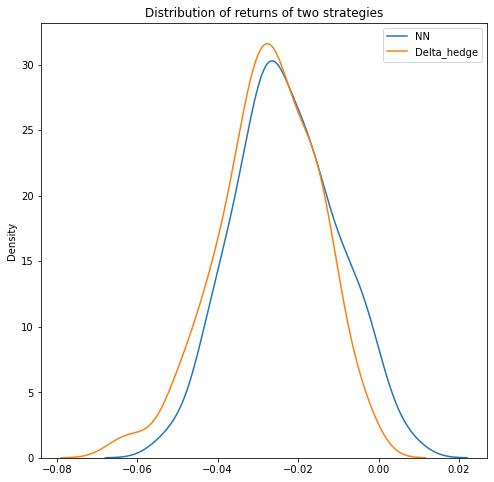

In [29]:
import seaborn as sns
plt.figure(figsize=(8,8))
plt.title("Distribution of returns of two strategies")
sns.kdeplot(test_res, fill=False,label="NN")
sns.kdeplot(test_res_delta,fill=False,label ="Delta_hedge")
plt.legend()

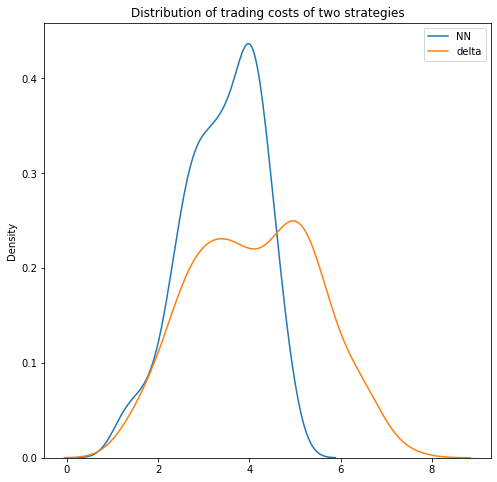

In [30]:
plt.figure(figsize=(8,8))
plt.title("Distribution of trading costs of two strategies")
sns.kdeplot(cost, fill=False,label="NN")
sns.kdeplot(costs_deta, fill=False,label="delta")
plt.legend()

In [34]:
pd.Series(test_res)

<ipython-input-34-a451aa57e95a>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(test_res)


Series([], dtype: float64)

In [35]:
test_res

[]